In [9]:
import collections
import math
import os
import random
import zipfile
import re 
import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [10]:
filepath='book1.txt'
with open(filepath,encoding='utf-8') as fp:
    words=fp.read()
   
special_chars = ["[!@#$,.;]", "%",'[“”?]','']
def string_cleanup(x, notwanted):
    for item in notwanted:
        x = re.sub(item, '', x)
    return x

words=string_cleanup(words,special_chars)
words=words.split()




print(len(list(set(words))))    

16727


In [11]:
vocabulary_size=15000
def build_dataset(words,vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary={}
    for word,i in count:
        dictionary.update({word:len(dictionary)})
    data=[]
    unk_count=0
    for word in words:
        if word in dictionary:
            index=dictionary[word]
        else:
            index=0
            unk_count+=1
        data.append(index)
    count[0][1]=unk_count
    reverse_dictionary=dict(zip(dictionary.values(),dictionary.keys()))
    return data, count , dictionary,reverse_dictionary
            
        
    
    
data,count,dictionary,reverse_dictionary=build_dataset(words,vocabulary_size)  

In [12]:
del words 

In [13]:
data_index = 0

def generate_batch(batch_size,num_skips,window):
    global data_index
    assert batch_size % num_skips==0
    assert num_skips<=2*window
    batch=np.ndarray(shape=[batch_size],dtype=np.int32)
    labels=np.ndarray(shape=[batch_size,1],dtype=np.int32)
    span=2*window+1
    buffer=collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target=window
        targets_to_avoid=[window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target=random.randint(0,span-1)
            targets_to_avoid.append(target)
            batch[i*num_skips+j]=buffer[window]
            labels[i*num_skips+j,0]=buffer[target]
        buffer.append(data[data_index])  
        data_index = (data_index + 1) % len(data)
    data_index = (data_index - span) % len(data)
    return batch, labels

             
        
        
    

In [14]:
batch_size=128
embedding_size=128
skip_window=1
num_skips=2
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.


In [21]:

graph = tf.Graph()

with graph.as_default():
    train_inputs=tf.placeholder(tf.int32,shape=[batch_size])
    train_labels=tf.placeholder(tf.int32,shape=[batch_size,1])
    valid_dataset=tf.constant(valid_examples,dtype=tf.int32)
    with tf.device('/cpu:0'):
        embeddings=tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
        embed=tf.nn.embedding_lookup(embeddings,train_inputs)
        nce_weights=tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/math.sqrt(embedding_size)))
        nce_biases=tf.Variable(tf.zeros([vocabulary_size]))
    loss=tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,biases=nce_biases,labels=train_labels,inputs=embed,num_sampled=num_sampled,num_classes=vocabulary_size))
    optimizer=tf.train.GradientDescentOptimizer(1.0).minimize(loss)    
    norm=tf.sqrt(tf.reduce_sum(tf.square(embeddings),axis=1,keep_dims=True))
    normalized_embeddings=embeddings/norm
    valid_embeddings=tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)
    similarity=tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True)
    init=tf.global_variables_initializer()
   


            
        
    

In [24]:
num_steps=5000000

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver({"embeddings": embeddings})

    init.run()
    print("initialized")
    average_loss=0
    for step in xrange(num_steps):
        batch_inputs,batch_labels= generate_batch(batch_size, num_skips, skip_window)
        feed_dict={train_inputs:batch_inputs,train_labels:batch_labels}
        _,loss_val=sess.run([optimizer,loss],feed_dict=feed_dict)
        average_loss+=loss_val
        if step %10000==0:
            sim=similarity.eval()
            for i in xrange(valid_size):
                valid_word=reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    save_path = saver.save(sess, "/tmp/word2vec.ckpt")
    #print("saved")
    final_embeddings = normalized_embeddings.eval()
    
    

initialized
Nearest to were: hatching, Cersei, grope, builders, daring, wingbone, Should, hears,
Nearest to would: greedy, Reclining, shrilled, Volantis, rainbow-colored, unwed, flowering, Win,
Nearest to but: Goodman, bothered, mothers, credence, length, badge, tallow, lumber,
Nearest to And: incite, To, m, telling, stonemason, Weasel, unshipped, man’d,
Nearest to back: emaciated, towerhouse, shadow, flashed, upriver, mortal, chop, concubines,
Nearest to all: Visenya, chewed, outriders, boyish, Return, dark, grunt, translucent,
Nearest to only: heir—and, Smooth, HORAS, purses, humming, ferry, expensive, pursuing,
Nearest to do: Sunderlies, untrained, uncertainty, oath, curses, pausing, Qohorik, albino,
Nearest to she: fought, husky, TANDA, filtering, BOROS, axe, figs, rack,
Nearest to He: discolored, TANTON, purse, Hard, stood, smashed, parceled, undeniably,
Nearest to off: spitting, flaying, horn, Edwyle, Jaremy, ghostly, inland, invaluable,
Nearest to as: wrists, —GENNA, Aurane, Ard

saved


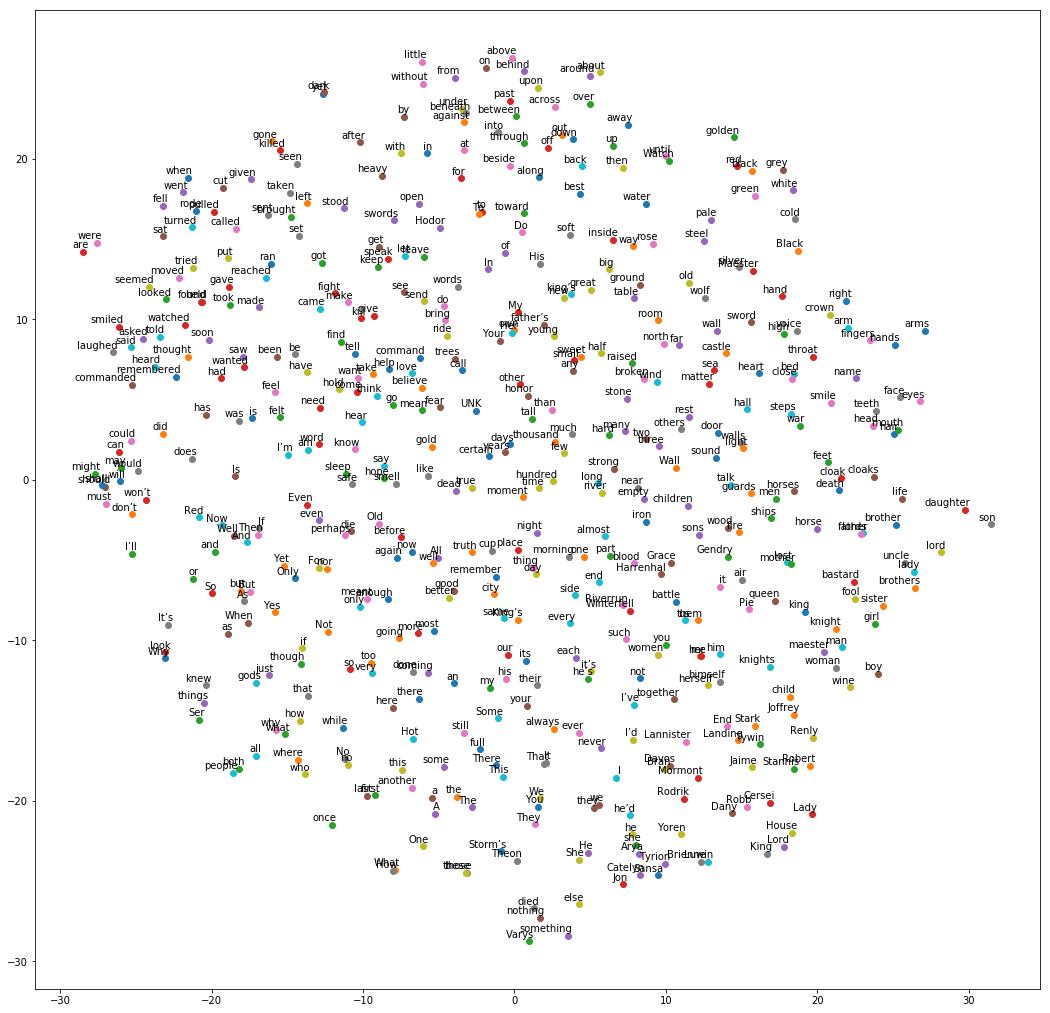

In [79]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    
    plt.savefig(filename)
    print("saved")
    plt.show()

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [ ]:
saver = tf.train.Saver({"embeddings": final_embeddings})